# Experiment 5

In [1]:
import time

import pandas as pd
import numpy as np

from tinycta.port import build_portfolio
from tinycta.linalg import *
from tinycta.signal import *

In [2]:
# Load prices
prices = pd.read_csv("data/Prices_hashed.csv", index_col=0, parse_dates=True).ffill()

In [3]:
from ipywidgets import Label, HBox, VBox, IntSlider, FloatSlider

fast = IntSlider(min=4, max=192, step=4, value=32)
slow = IntSlider(min=4, max=192, step=4, value=96)
vola = IntSlider(min=4, max=192, step=4, value=32)
winsor = FloatSlider(min=1.0, max=6.0, step=0.1, value=4.2)
corr = IntSlider(min=50, max=500, step=10, value=200)
shrinkage = FloatSlider(min=0.0, max=1.0, step=0.05, value=0.5)
left_box = VBox([Label("Fast Moving Average"), 
                 Label("Slow Moving Average"), 
                 Label("Volatility"), 
                 Label("Winsorizing"),
                 Label("Correlation"),
                 Label("Shrinkage")])

right_box = VBox([fast, slow, vola, winsor, corr, shrinkage])
HBox([left_box, right_box])

In [4]:
T = time.time()
correlation = corr.value

# this is a lot faster than Pandas...
position = np.nan*np.zeros_like(prices.values)

returns_adj = prices.apply(returns_adjust, com=vola.value, clip=winsor.value)
# DCC by Engle
cor = returns_adj.ewm(com=corr.value, min_periods=corr.value).corr()

mu = np.tanh(returns_adj.cumsum().apply(osc)).values
vo = prices.pct_change().ewm(com=vola.value, min_periods=vola.value).std().values

for n,t in enumerate(prices.index):
    matrix = shrink2id(cor.loc[t].values, lamb=shrinkage.value)
    risk_position = solve(matrix, mu[n])/inv_a_norm(mu[n], matrix)
    position[n] = risk_position/vo[n]

portfolio = build_portfolio(prices, 1e6*pd.DataFrame(index=prices.index, columns=prices.keys(), data=position), aum=1e9)
print(time.time()-T)


/home/thomas/projects/cs/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1189009/3708082871.py:12: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  vo = prices.pct_change().ewm(com=vola.value, min_periods=vola.value).std().values


10.612603425979614


# Conclusions
* Dramatic relativ improvements observable despite using the same signals as in previous Experiment.
* Main difference here is to take advantage of cross-correlations in the risk measurement.
* Possible to add constraints on individual assets or groups of them.
* Possible to reflect trading costs in objective with regularization terms (Ridge, Lars, Elastic Nets, ...)

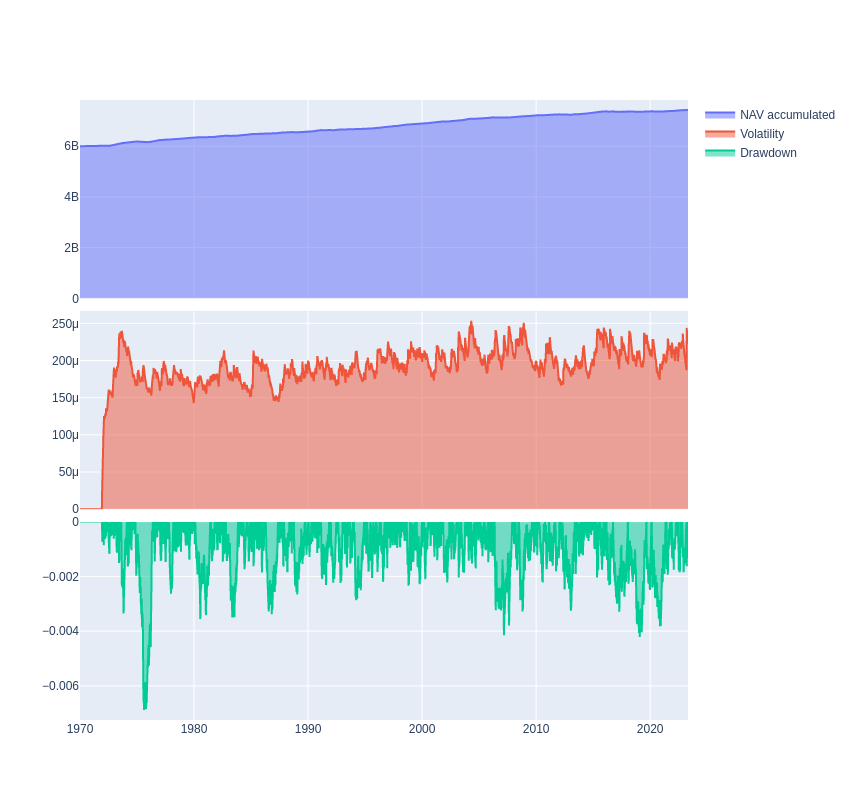

In [5]:
portfolio.plot()

In [6]:
portfolio.metrics()

{'Sharpe': 1.410994904013865,
 'Kurtosis': 1.4011526579892135,
 'Skewness': -0.17164970126492798,
 'Annualized Volatility (%)': 0.3061902161677298,
 'Annualized Return (%)': 0.4320328346715705}